<a href="https://colab.research.google.com/github/hansglick/book_errata/blob/main/008_VAE_custom_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Objectif

L'objectif du notebook est de construire un VAE from scratch sur les données keras MNIST disponibles ic : tf.keras.datasets.mnist.load_data(). Cela se fera en plusieurs étapes :

# Pense bete Concernant le subclassing
 * def __init__(self,.., **kwargs):
 * super(nom de la nouvelle classe, self).__init__(name=name, **kwargs)
 * def call(self, inputs):
 * super suit juste aprèsle init
 


### Step 1 - Custom Sampling Layer
Ici on veut subclasser layer pour créer un le sampling layer du VAE :     
 * 2 inputs : z_mean et z_log_var qui sont deux concaténés dans le dernier layer de l'encoder
 * Création du vecteur epsilon qui est de la mm taille que z_mean et qui contient des données issues du loi normale centrée réduite
 * Transformation de z_log_var en exponentiel(0.5*z_log_var)
 * Renvoyer la somme de t(z_log_var) et epsilon
 * Extrêmement simple car les calculs de dépendent que de l'input du layer

### Step 2 - Custom Encoder Layer
Ici on subclass layer pour obtenir la première partie du VAE, i.e. l'encoder. Celui-ci doit renvoyer un tuple (z_mean, z_log_var, et z qui est la solution finale). La raison pour laquelle on garde z_mean et z_log_var c'est parce qu'on en aura besoin plus tard lors du calcul de la loss dans le model
 * latent dim
 * intermediate dim

### Step 3 - Custom Decoder Layer
Ici on sublcass layer pour obtenir la derniere partie du VAE, le decoder. Celui-ci prend comme input le z de l'encoder et va le décompresser jusqu'à lla shape de l'image original
 * original dim
 * intermediate dim

### Step 4 - Custom Model
Ici on subclass Model de sorte à créer un nouveay modèle préprogrammé de tensorflow, un VAE, les inputs de celui-ci :     
 * original dimension
 * intermediate dimension
 * latent dimension

### Step 5 - Récupération et Préprocessing des données
Ici on veut récupérer les données, en faire un dataset object. On veut également préprocesser les données qui sont sous format rgb :    
 * / 255
 * Flatten l'image
 * Les foutre en float


### Step 6 - Custom loop de training
Ce qu'on veut :    
 * loss : mean square error + kl divergence
 * accumulateur loss : moyenne
 * on fait aussi le tape gradient


# Schéma d'un VAE
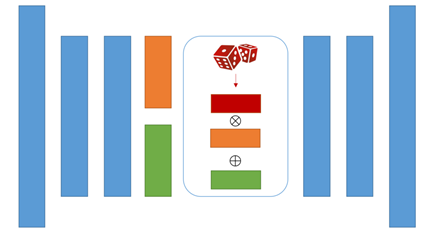

In [95]:
# Pour simuler une normale
# tf.keras.backend.random_normal(shape=(batch, dim))

# Pour prendre une exponentielle, utiliser les fonctions tensorflow tf.exp
# tf.exp(0.5 * z_log_var)

# Pour sublclasser
# class Sampling(layers.Layer)
# class VariationalAutoEncoder(keras.Model)

# Un layer peut prendre comme input call un tuple de layer !!!

# C'est dans le subclassing de model dans le call qu'on calcule la loss
# via self.add_loss(the_loss_to_add)

# La KL divergence est égale à la moyenne du vecteur résultant d'opérations sur 
# z_mean et z_log_var
# KL = -0.5 * Moyenne [ z_log_var - racine_carre(z_mean) - exp(z_log_var) + 1]

# Warning : tf.reshape transforme un numpy array en eager tensor
# Du coup utilisez .reshape de numpy si on veut conserver un numpy

# take method de tensorflow dataset prend x élément au hasard et les fout dans un générator
# Pour accéder à la valeur d'un générateur qui sort un tensor utilisez la méthode .numpy()

# Pour les fonctions loss ne pas confondre
# tf.keras.losses.MeanSquaredError() qui renvoie l'instanciation d'un objet qui peut s'appliquer alors comme une fonction 
# avec
# tf.keras.losses.mean_squared_error qui est une fonction et non l'instanciation d'un objet

# Pour mettre à jour les gradient on attend un iterateur de tuples (pente,variable)
# optimizer.apply_gradients(zip(grads,model.trainable_weights))


In [96]:
class Sampling_Layer (tf.keras.layers.Layer):

  """
  Le layer sampling dans un VAE
  """

  def call(self,inputs):
    z_mean,z_log_var = inputs

    # Récupération de la shape de z_mean
    batch = z_mean.shape[0]
    dim = z_mean.shape[-1]

    # Simulation de random normale
    epsilon = tf.keras.backend.random_normal(shape = (batch,dim))

    # Transformation de z_log_var
    tz_log_var = tf.exp(0.5 * z_log_var)

    # Retourne le sampling
    sampling = epsilon + tz_log_var

    return sampling

In [97]:
class Encoder(tf.keras.layers.Layer):

  """
  Le layer Encoder du VAE
  
  INPUTS : 
  - Intermediate dimension
  - Latent dimension

  OUTPUTS : 
  - triplet : z_mean,z_log_var,sampling
  """

  def __init__(self,latent_dimension,intermediate_dimension,name = "Encoder",**kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.denseA = tf.keras.layers.Dense(units = intermediate_dimension, activation = "relu")
    self.denseB = tf.keras.layers.Dense(units = latent_dimension)
    self.denseC = tf.keras.layers.Dense(units = latent_dimension)
    self.sampling = Sampling_Layer()

  def call(self,inputs):
    proj = self.denseA(inputs)
    z_mean = self.denseB(proj)
    z_log_var =self.denseC(proj)
    sampling = self.sampling((z_mean,z_log_var))
    return z_mean,z_log_var,sampling
    


In [98]:
class Decoder(tf.keras.layers.Layer):

  """
  Le Decoder Layer d'un VAE
  inputs :
  - Original dimension
  - Intermediate dimension 
  """

  def __init__(self,intermediate_dimension,original_dimension,name = "Decoder",**kwargs):
    super(Decoder,self).__init__(name=name, **kwargs)
    self.denseA = tf.keras.layers.Dense(units = intermediate_dimension, activation =  "relu")
    self.denseB = tf.keras.layers.Dense(units = original_dimension, activation = "sigmoid")

  def call(self,inputs):
    x = self.denseA(inputs)
    x = self.denseB(x)
    return x


In [117]:
class Custom_VAE(tf.keras.models.Model):
  """
  Création d'une classe DE VAE à partir du sublcassing de Model
  """

  def __init__(self,original_dimension,intermediate_dimension,latent_dimension,name = "Custom_VAE",**kwargs):
    super(Custom_VAE,self).__init__(name = name,**kwargs)
    self.encoder_layer = Encoder(latent_dimension,intermediate_dimension)
    self.decoder_layer = Decoder(intermediate_dimension,original_dimension)

  def call(self,inputs):
    z_mean,z_log_var,sampling = self.encoder_layer(inputs)
    x = self.decoder_layer(sampling)

    # Calcul de la KL Loss
    # KL = -0.5 * Moyenne [ z_log_var - racine_carre(z_mean) - exp(z_log_var) + 1]
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

    # Ajout de la loss
    self.add_loss(kl_loss)

    return x



In [132]:
# Parameters
original_dimension = 784
intermediate_dimension = 64
latent_dimension = 32
epochs = 5

In [133]:
# Récupération et Processing des données
(x_train,y_train),_ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],original_dimension).astype("float32")/255

# Création d'un dataset object
training_dataset = tf.data.Dataset.from_tensor_slices(x_train)
training_dataset = training_dataset.shuffle(buffer_size=1024).batch(64)

In [134]:
# Définitions des composants nécessaire à la custom loop
model = Custom_VAE(original_dimension,intermediate_dimension,latent_dimension)
loss_mse = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean() # accumulator
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [135]:
# Custom loop

for _ in range(epochs):

  for step,batch in enumerate(training_dataset):
    with tf.GradientTape() as tape :
      predictions = model(batch)
      loss = loss_mse(batch,predictions) + tf.reduce_sum(model.losses)
    
    # Récupération des pentes , i.e. les gradients
    grads = tape.gradient(loss,model.trainable_weights)

    # Mise à jour des gradients
    optimizer.apply_gradients(zip(grads,model.trainable_weights))

    # Accumulation sur tout les batch de la loss, moyenne sur tout les batch en cours
    loss_metric(loss)

    # Le display
    if step % 1000 == 0:
      print("step %d: mean loss = %.4f" % (step, loss_metric.result()))


step 0: mean loss = 0.3581
step 0: mean loss = 0.0716
step 0: mean loss = 0.0696
step 0: mean loss = 0.0689
step 0: mean loss = 0.0685
